In [1]:
from ultralytics import YOLO
import cv2 as cv
from PIL import Image
from torchvision import models
import torch
from torchvision import transforms
from torch.nn.functional import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.ops import generalized_box_iou
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

import os, time
import cv2, random
import pickle, joblib
import sklearn.metrics
import numpy as np
np.set_printoptions(suppress=True)
import gurobipy as gp

import torch
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(sci_mode=False)
from torch_geometric.data import Data

from lib.tracking import Tracker
from lib.qpthlocal.qp import QPFunction, QPSolvers
from lib.utils import getIoU, interpolateTrack, interpolateTracks

In [3]:
def build_edge_index_from_gt_consecutive(gt):
    """
    Build edge_index from ground_truth connecting only consecutive frames,
    and generate edge labels indicating if the connected nodes belong to the same object.
    
    Args:
        gt: np.ndarray of shape (N, 9), with frame index in column 0 and object_id in column 1
    
    Returns:
        edge_index: torch.LongTensor of shape [2, num_edges]
        edge_labels: torch.BoolTensor of shape [num_edges] (True if same object ID)
    """
    edge_list = []
    label_list = []
    num_nodes = gt.shape[0]
    timestamps = gt[:, 0].astype(int)
    object_ids = gt[:, 1].astype(int)

    for i in range(num_nodes):
        for j in range(num_nodes):
            if timestamps[j] - timestamps[i] == 1:
                edge_list.append((i, j))
                label_list.append(object_ids[i] == object_ids[j])  # True if same object

    edge_index = torch.tensor(edge_list, dtype=torch.long).T  # shape [2, num_edges]
    edge_labels = torch.tensor(label_list, dtype=torch.bool)  # shape [num_edges]

    return edge_index, edge_labels

In [4]:
def computeBoxFeatures(bbox1, bbox2):
    """
    Assuming bbox1, bbox2 are in the xmin, ymin, xmax, ymax format
    """
    xmin_1, ymax_1 = bbox1[0], bbox1[3]
    xmin_2, ymax_2 = bbox2[0], bbox2[3]
    width_1, height_1 = bbox1[2] - bbox1[0], bbox1[3] - bbox1[1]
    width_2, height_2 = bbox2[2] - bbox2[0], bbox2[3] - bbox2[1]

    y_rel_dist = 2 * (ymax_1 - ymax_2) / (height_1 + height_2)
    x_rel_dist = 2 * (xmin_1 - xmin_2) / (height_1 + height_2)
    y_rel_size = np.log(height_1 / height_2)
    x_rel_size = np.log(width_1 / width_2)
    return [y_rel_dist, x_rel_dist, y_rel_size, x_rel_size]

def getIoU(bbox1, bbox2):
    """
    Assuming bbox1, bbox2 are in the xmin, ymin, xmax, ymax format
    """
    ixmin = max(bbox1[0], bbox2[0])
    ixmax = min(bbox1[2], bbox2[2])
    iymin = max(bbox1[1], bbox2[1])
    iymax = min(bbox1[3], bbox2[3])

    iw = np.maximum(ixmax-ixmin+1., 0.)
    ih = np.maximum(iymax-iymin+1., 0.)
    intersection = iw*ih
    
    union = ((bbox1[2]-bbox1[0]+1.) * (bbox1[3]-bbox1[1]+1.)+(bbox2[2]-bbox2[0]+1.) * (bbox2[3]-bbox2[1]+1.)-intersection)
    iou = intersection / union
    return iou

def get_trans_probs(curr_dets, curr_app_feats, app_thresh, max_frame_gap = 5):
    """
    Inputs: tracker: an instance of the Tracker.
            curr_dets: frame, x1, y1, x2, y2, det_confidence, node_ind.
            curr_app_feats: normalized appearance features for curr_dets.
            max_frame_gap: frame gap used to connect detections.
    Return: transition probabilities for LP that handles false negatives(missing detections).
    """
    edge_ind = 0
    edge_feats, lifted_probs = [], []
    edge_type = [] #1:base edge 2:lifted edge-1:pruned lifted edge
    
    cos_sim_mat = np.dot(curr_app_feats, curr_app_feats.T)
    linkIndexGraph = np.zeros((curr_dets.shape[0], curr_dets.shape[0]), dtype=np.int32)
    for i in range(curr_dets.shape[0]):
        for j in range(curr_dets.shape[0]):
            frame_gap = curr_dets[j][0] - curr_dets[i][0]
            cos_sim = cos_sim_mat[i, j]

            if frame_gap == 1: #base edge
                edge_type.append(1)
                feats = computeBoxFeatures(curr_dets[i, 1:5], curr_dets[j, 1:5])
                iou = getIoU(curr_dets[i, 1:5], curr_dets[j, 1:5])
                feats.extend((iou, cos_sim))
                edge_feats.append(feats)
                edge_ind += 1
                linkIndexGraph[i, j] = edge_ind

            elif frame_gap > 1 and frame_gap <= max_frame_gap: #lifted edge
                if cos_sim > app_thresh:
                    edge_type.append(2)
                    time_weight = 0.9 ** frame_gap
                    lifted_probs.append(cos_sim * time_weight)
                else:
                    edge_type.append(-1)

                edge_ind += 1
                linkIndexGraph[i, j] = edge_ind
                
    edge_type = np.array(edge_type)
    edge_feats = torch.Tensor(edge_feats)
    return edge_feats

def compute_edge_features_from_gt(ground_truth, features, edge_index):
    """
    Compute edge features using spatial-temporal box features, appearance similarity, and IoU.
    
    Args:
        ground_truth: np.ndarray [num_nodes, 9] → [frame, id, bb_left, bb_top, bb_width, bb_height, x, y, z]
        features: np.ndarray [num_nodes, feature_dim] → appearance features
        edge_index: np.ndarray [2, num_edges] → source and destination indices
    
    Returns:
        edge_features: np.ndarray [num_edges, 6]
    """
    num_edges = edge_index.shape[1]
    edge_features = np.zeros((num_edges, 6))  # 4 geom + 1 sim + 1 IoU

    for idx in range(num_edges):
        i = edge_index[0, idx]  # source node
        j = edge_index[1, idx]  # target node

        # Extract bboxes in (xmin, ymin, xmax, ymax) format
        x1, y1, w1, h1 = ground_truth[i, 2:6]
        x2, y2, w2, h2 = ground_truth[j, 2:6]

        bbox1 = [x1, y1, x1 + w1, y1 + h1]
        bbox2 = [x2, y2, x2 + w2, y2 + h2]

        # 1. Spatial-temporal geometric features
        geom_feats = computeBoxFeatures(bbox1, bbox2)

        # 2. Appearance similarity (cosine)
        phi_i = features[i]
        phi_j = features[j]
        cosine_sim = np.dot(phi_i, phi_j) / (np.linalg.norm(phi_i) * np.linalg.norm(phi_j) + 1e-6)

        # 3. IoU
        iou = getIoU(bbox1, bbox2)

        # Combine
        edge_features[idx] = np.array(geom_feats + [iou, cosine_sim])

    return edge_features

In [5]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load pretrained ResNet50 model without the final classification layer
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet.to(device)
resnet.eval()

# 2. Define image transformation pipeline
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 3. Custom dataset to apply transforms
class ImageDataset(Dataset):
    def __init__(self, images, transform):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.transform(self.images[idx])

/home/khanh/miniconda3/envs/LPT/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/khanh/miniconda3/envs/LPT/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
for data_name in tqdm(['MOT16-02', 'MOT16-05', 'MOT16-09', 'MOT16-11', 'MOT16-13']):
    label_path = f"/home/khanh/data/LPT/data/MOT16/train/{data_name}/gt/gt.txt"
    video_path = f"/home/khanh/data/LPT/data/MOT16/train/{data_name}/img1"
    frame_names = os.listdir(video_path)
    frame_names.sort()
    frame_path_list = [os.path.join(video_path, frame_names[i]) for i in range(len(frame_names))]
    # <frame>, <id>, <bb_left>, <bb_top>, <bb_width>, <bb_height>, <x>, <y>, <z>
    gt = []
    with open(label_path, 'r') as f:
        for l in f.readlines():
            l = l.strip().split(',')
            gt.append([int(i) for i in l[:-1]] + [float(l[-1])])
    gt = np.array(gt)
    gt[:,4:6] = gt[:,2:4] + gt[:,4:6]
    with open(f'/home/khanh/data/LPT/data/train_data/{data_name}.pkl', 'rb') as f:
        data_list = pickle.load(f)
    
    video_frames = [None]
    for path in frame_path_list:
        video_frames.append(Image.open(path).convert('RGB'))
        
    chunk_length = 15
    step_frame = 4
    new_data_list = []
    for begin_frame_id in range(1, len(frame_path_list), step_frame):
        end_frame_id = begin_frame_id + chunk_length
        chunk_gt = gt[np.logical_and(gt[:, 0] >= begin_frame_id, gt[:, 0] <= end_frame_id)]
    
    # for i in tqdm(range(len(data_list))):
        # gt = np.array(gt)
        # gt = gt[np.logical_and(gt[:, 0] >= begin_frame_id, gt[:, 0] <= end_frame_id)]
        edge_index, y = build_edge_index_from_gt_consecutive(chunk_gt)
    
        isinstance_PIL = []
        for instance in chunk_gt:
            isinstance_PIL.append(video_frames[int(instance[0])].crop(instance[2:6]))
    
        instance_embedding = []
        dataset = ImageDataset(isinstance_PIL, transform)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
        with torch.no_grad():
            for batch in dataloader:
                batch = batch.to(device)
                output = resnet(batch).squeeze(-1).squeeze(-1)  # Shape: (B, 2048)
                embeddings = output.cpu()  # Move to CPU if needed
                instance_embedding.extend(embeddings)
        instance_embedding = torch.stack(instance_embedding)
    
        edge_attr = compute_edge_features_from_gt(chunk_gt, instance_embedding, edge_index)
    
        # assert (y == data_list[i].y).all()
        # assert (edge_index == data_list[i].edge_index).all()
    
        data = Data(x=instance_embedding, edge_index=edge_index, edge_attr = edge_attr)
        data.ground_truth = chunk_gt
        data.sequence=data_name
        data.y = y
        new_data_list.append(data)
    
    with open(f"reproduce_dataset/{data_name}.pkl", "wb") as f:
        pickle.dump(new_data_list, f)

/tmp/ipykernel_3271077/697886525.py:26: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  edge_labels = torch.tensor(label_list, dtype=torch.bool)  # shape [num_edges]
/tmp/ipykernel_3271077/2383407829.py:108: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  cosine_sim = np.dot(phi_i, phi_j) / (np.linalg.norm(phi_i) * np.linalg.norm(phi_j) + 1e-6)
100%|███████████████████████████████████████████████████████████████████████████████████████████| 5/5 [21:39<00:00, 259.93s/it]


In [6]:
# RELOAD FROM AUTHOR'S PREPROCESS FILE

for data_name in ['MOT16-02', 'MOT16-05', 'MOT16-09', 'MOT16-11', 'MOT16-13']:
    # data_name = "MOT16-11"
    label_path = f"/home/khanh/data/LPT/data/MOT16/train/{data_name}/gt/gt.txt"
    video_path = f"/home/khanh/data/LPT/data/MOT16/train/{data_name}/img1"
    frame_names = os.listdir(video_path)
    frame_names.sort()
    frame_path_list = [os.path.join(video_path, frame_names[i]) for i in range(len(frame_names))]
    # <frame>, <id>, <bb_left>, <bb_top>, <bb_width>, <bb_height>, <x>, <y>, <z>
    gt = []
    with open(label_path, 'r') as f:
        for l in f.readlines():
            l = l.strip().split(',')
            gt.append([int(i) for i in l[:-1]] + [float(l[-1])])
    with open(f'/home/khanh/data/LPT/data/train_data/{data_name}.pkl', 'rb') as f:
        data_list = pickle.load(f)
    
    video_frames = [None]
    for path in frame_path_list:
        video_frames.append(Image.open(path).convert('RGB'))
    
    new_data_list = []
    for i in tqdm(range(len(data_list))):
        # gt = np.array(gt)
        # gt = gt[np.logical_and(gt[:, 0] >= begin_frame_id, gt[:, 0] <= end_frame_id)]
        gt = data_list[i].ground_truth
        edge_index, y = build_edge_index_from_gt_consecutive(gt)
    
        isinstance_PIL = []
        for instance in gt:
            isinstance_PIL.append(video_frames[int(instance[0])].crop(instance[2:6]))
    
        instance_embedding = []
        dataset = ImageDataset(isinstance_PIL, transform)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
        with torch.no_grad():
            for batch in dataloader:
                batch = batch.to(device)
                output = resnet(batch).squeeze(-1).squeeze(-1)  # Shape: (B, 2048)
                embeddings = output.cpu()  # Move to CPU if needed
                instance_embedding.extend(embeddings)
        instance_embedding = torch.stack(instance_embedding)
    
        edge_attr = compute_edge_features_from_gt(gt, instance_embedding, edge_index)

        assert (y == data_list[i].y).all()
        assert (edge_index == data_list[i].edge_index).all()
    
        data = Data(x=instance_embedding, edge_index=edge_index, edge_attr = edge_attr)
        data.ground_truth = gt
        data.sequence=data_name
        data.y = y
        new_data_list.append(data)
    
    with open(f"reproduce_dataset/{data_name}.pkl", "wb") as f:
        pickle.dump(new_data_list, f)

KeyboardInterrupt: 

/tmp/ipykernel_2176483/2383407829.py:108: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.| 0/225 [00:00<?, ?it/s]
  cosine_sim = np.dot(phi_i, phi_j) / (np.linalg.norm(phi_i) * np.linalg.norm(phi_j) + 1e-6)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [01:48<00:00,  2.08it/s]


In [466]:
data_list[0].y[:100]

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [452]:
data_list[0]

Data(edge_attr=[4025, 6], edge_index=[2, 4025], ground_truth=[[  1.        1.      867.      ...   1.        1.        1.     ]
 [  2.        1.      870.      ...   1.        1.        1.     ]
 [  3.        1.      873.      ...   1.        1.        1.     ]
 ...
 [ 14.       79.      826.      ...   1.        1.        0.56863]
 [ 15.       79.      826.      ...   1.        1.        0.45098]
 [ 16.       79.      829.      ...   1.        1.        0.29412]], sequence="MOT16-11", x=[261, 512], y=[4025])

In [469]:
data.edge_attr.shape

(4025, 6)

In [472]:
data

Data(edge_attr=[[ 0.         -0.00384862  0.00128287  0.0045434   0.9941964   0.93546784]
 [-0.21316614  0.97283177 -0.37421256  1.16514736  0.          0.77080798]
 [ 0.0842411   0.68264343  0.26737681  0.76356575  0.02353746  0.7165367 ]
 ...
 [-0.03063457 -1.01750547 -0.00437637 -0.41756813  0.22132408  0.58457983]
 [-0.0504386  -1.07675439  0.         -0.43175277  0.19703722  0.6004703 ]
 [-0.01311475 -0.00655738 -0.0065574  -0.00341881  0.97065263  0.93862587]], edge_index=[2, 4025], ground_truth=[[  1.        1.      867.      ...   1.        1.        1.     ]
 [  2.        1.      870.      ...   1.        1.        1.     ]
 [  3.        1.      873.      ...   1.        1.        1.     ]
 ...
 [ 14.       79.      826.      ...   1.        1.        0.56863]
 [ 15.       79.      826.      ...   1.        1.        0.45098]
 [ 16.       79.      829.      ...   1.        1.        0.29412]], sequence="MOT16-11", x=[261, 2048])

array([[  1.     ,   1.     , 867.     , ...,   1.     ,   1.     ,   1.     ],
       [  2.     ,   1.     , 870.     , ...,   1.     ,   1.     ,   1.     ],
       [  3.     ,   1.     , 873.     , ...,   1.     ,   1.     ,   1.     ],
       ...,
       [ 14.     ,  79.     , 826.     , ...,   1.     ,   1.     ,   0.56863],
       [ 15.     ,  79.     , 826.     , ...,   1.     ,   1.     ,   0.45098],
       [ 16.     ,  79.     , 829.     , ...,   1.     ,   1.     ,   0.29412]])

In [369]:
data_list[0].edge_attr

tensor([[     0.0016,     -0.0047,      0.0032,      0.0345,      0.9632,      0.9895],
        [    -0.3991,      1.0496,     -0.5843,     -0.5474,      0.0000,      0.4159],
        [     0.3805,      0.9771,      0.6637,      0.7017,      0.0000,      0.4950],
        ...,
        [    -0.0174,     -4.0435,      0.0870,      0.2485,      0.0000,      0.5434],
        [     0.0000,     -4.5253,      0.2128,      0.4463,      0.0000,      0.5517],
        [    -0.0250,     -0.0250,      0.0000,      0.0000,      0.8482,      0.8997]])

In [405]:
dets = gt
app_feats = np.random.rand(len(dets), 1024)

curr_ind = [True] * len(dets)
curr_dets = np.concatenate([dets[curr_ind,0][:, None], dets[curr_ind, 2:7],
                                        np.arange(dets[curr_ind].shape[0])[:, None]], axis=1)
curr_dets[:, 3:5] = curr_dets[:, 3:5] + curr_dets[:, 1:3] # convert to frame,x1,y1,x2,y2,conf,node_ind
curr_app_feats = app_feats[curr_ind]
curr_app_feats = curr_app_feats / np.linalg.norm(curr_app_feats, axis=1, keepdims=True)

get_trans_probs(curr_dets, curr_app_feats, app_thresh=0, max_frame_gap = 5)

tensor([[ 0.0000, -0.0038,  0.0013,  0.0045,  0.9942,  0.7424],
        [-0.2132,  0.9728, -0.3742,  1.1651,  0.0000,  0.7454],
        [ 0.0842,  0.6826,  0.2674,  0.7636,  0.0235,  0.7588],
        ...,
        [-0.0306, -1.0175, -0.0044, -0.4176,  0.2213,  0.7450],
        [-0.0504, -1.0768,  0.0000, -0.4318,  0.1970,  0.7592],
        [-0.0131, -0.0066, -0.0066, -0.0034,  0.9707,  0.7466]])

In [403]:
(torch.tensor(compute_edge_features_from_gt(gt, torch.rand(len(gt), 1024), edge_index)) - get_trans_probs(curr_dets, curr_app_feats, app_thresh=0, max_frame_gap = 5)).mean()

/tmp/ipykernel_2109995/2193469514.py:65: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  cosine_sim = np.dot(phi_i, phi_j) / (np.linalg.norm(phi_i) * np.linalg.norm(phi_j) + 1e-6)


tensor(0.0002, dtype=torch.float64)

In [ ]:
dets = gt
app_feats = np.random.rand(len(dets), 1024)

In [395]:
def compute_edge_features(ground_truth, features, edge_index):
    """
    Compute edge features between detections using spatial, appearance, and GIoU.
    
    Args:
        ground_truth: np.ndarray [num_nodes, 9] → [frame, id, bb_left, bb_top, bb_width, bb_height, x, y, z]
        features: torch.Tensor [num_nodes, feature_dim]
        edge_index: torch.LongTensor [2, num_edges]
    
    Returns:
        edge_features: torch.Tensor [num_edges, 6]
    """
    device = features.device
    ground_truth = torch.tensor(ground_truth, dtype=torch.float32, device=device)

    # Extract bbox info
    xi = ground_truth[:, 2]  # bb_left
    yi = ground_truth[:, 3]  # bb_top
    wi = ground_truth[:, 4]  # bb_width
    hi = ground_truth[:, 5]  # bb_height

    bboxes = torch.stack([xi, yi, wi, hi], dim=1)  # [num_nodes, 4]

    src_idx = edge_index[0]
    dst_idx = edge_index[1]

    xi, yi, wi, hi = bboxes[src_idx].T
    xj, yj, wj, hj = bboxes[dst_idx].T

    eps = 1e-6
    h_sum = hi + hj + eps

    # Geometric features
    dx = 2 * (xj - xi) / h_sum
    dy = 2 * (yj - yi) / h_sum
    log_h_ratio = torch.log((hi + eps) / (hj + eps))
    log_w_ratio = torch.log((wi + eps) / (wj + eps))

    # Appearance similarity (cosine similarity)
    norm_feat = F.normalize(features, dim=1)
    sim = (norm_feat[src_idx] * norm_feat[dst_idx]).sum(dim=1)

    # GIoU
    def xywh_to_xyxy(b):
        x1 = b[:, 0]
        y1 = b[:, 1]
        x2 = b[:, 0] + b[:, 2]
        y2 = b[:, 1] + b[:, 3]
        return torch.stack([x1, y1, x2, y2], dim=1)

    boxes_i = xywh_to_xyxy(bboxes[src_idx])
    boxes_j = xywh_to_xyxy(bboxes[dst_idx])
    giou = generalized_box_iou(boxes_i, boxes_j).diag()

    # Combine all edge features
    edge_features = torch.stack([dx, dy, log_h_ratio, log_w_ratio, giou, sim], dim=1)
    return edge_features

In [64]:
def cosine_similarity(vec1, vec2):
    vec1 = torch.tensor(vec1, dtype=torch.float32)
    vec2 = torch.tensor(vec2, dtype=torch.float32)

    # Compute dot product and norms
    dot_product = torch.dot(vec1, vec2)
    norm_vec1 = torch.norm(vec1)
    norm_vec2 = torch.norm(vec2)

    if norm_vec1 == 0 or norm_vec2 == 0:
        return torch.tensor(0.0)

    similarity = dot_product / (norm_vec1 * norm_vec2)
    return similarity

In [73]:
def track_objects_between_frames(frame1_objects, frame2_objects):
    """
    Track objects between two frames using ResNet embeddings and cosine similarity.
    
    Args:
        frame1_objects: List of M cropped object bounding boxes from frame 1 (PIL Images)
        frame2_objects: List of N cropped object bounding boxes from frame 2 (PIL Images)
        
    Returns:
        similarity_matrix: MxN matrix with cosine similarity scores
    """
    # 1. Load ResNet model
    resnet = models.resnet50(pretrained=True)
    # Remove the final classification layer
    resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))
    resnet.eval()
    
    # 2. Define image transformations (same as ResNet training)
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    # 3. Extract embeddings for frame 1 objects
    frame1_embeddings = []
    for obj in frame1_objects:
        # Apply transformations
        img_tensor = transform(obj).unsqueeze(0)
        
        # Get embedding
        with torch.no_grad():
            embedding = resnet(img_tensor)
            
        # Flatten the embedding
        embedding = embedding.squeeze().flatten()
        frame1_embeddings.append(embedding)
    
    # 4. Extract embeddings for frame 2 objects
    frame2_embeddings = []
    for obj in frame2_objects:
        # Apply transformations
        img_tensor = transform(obj).unsqueeze(0)
        
        # Get embedding
        with torch.no_grad():
            embedding = resnet(img_tensor)
            
        # Flatten the embedding
        embedding = embedding.squeeze().flatten()
        frame2_embeddings.append(embedding)
    
    # 5. Compute cosine similarity between all pairs of objects
    M = len(frame1_objects)
    N = len(frame2_objects)
    similarity_matrix = torch.zeros((M, N))
    
    for i in range(M):
        for j in range(N):
            similarity_matrix[i, j] = cosine_similarity(
                frame1_embeddings[i].unsqueeze(0),
                frame2_embeddings[j].unsqueeze(0)
            )
    
    return similarity_matrix, frame1_objects, frame2_objects

def visualize_similarity_matrix_improved(similarity_matrix, frame1_objects, frame2_objects):
    """
    Visualize the similarity matrix with improved layout matching the example.
    
    Args:
        similarity_matrix: MxN torch tensor with cosine similarity scores
        frame1_objects: List of frame 1 objects (PIL Images)
        frame2_objects: List of frame 2 objects (PIL Images)
    """
    M = len(frame1_objects)
    N = len(frame2_objects)
    
    # Convert similarity matrix to numpy for visualization
    sim_matrix_np = similarity_matrix.numpy()
    
    # Create figure with appropriate size
    fig = plt.figure(figsize=(14, 12))
    
    # Create the main layout
    # We'll have a left column for frame 1 objects, a top row for frame 2 objects,
    # and the main similarity matrix
    
    # For left column width and top row height (adjust as needed)
    left_col_width = 0.15  
    top_row_height = 0.15
    
    # Main similarity matrix
    ax_sim = plt.axes([left_col_width, 0.15, 0.72, 0.7])
    im = ax_sim.imshow(sim_matrix_np, cmap='viridis', vmin=0, vmax=1)
    ax_sim.set_xticks(range(N))
    ax_sim.set_yticks(range(M))
    ax_sim.set_xticklabels([f"{j}" for j in range(N)])
    ax_sim.set_yticklabels([f"{i}" for i in range(M)])
    ax_sim.set_xlabel('Frame 2 Objects')
    ax_sim.set_ylabel('Frame 1 Objects')
    
    # Add colorbar
    cbar_ax = plt.axes([0.88, 0.15, 0.03, 0.7])
    plt.colorbar(im, cax=cbar_ax, label='Cosine Similarity')
    
    # Set the title
    ax_title = plt.axes([0, 0.9, 0.15, 0.1])
    ax_title.text(0.5, 0.5, 'Similarity Matrix', ha='center', va='center', fontsize=12, fontweight='bold')
    ax_title.axis('off')
    
    # Add frame 2 objects on the top
    thumbnail_width = 0.72 / N
    for j in range(N):
        ax = plt.axes([left_col_width + j * thumbnail_width, 0.9, thumbnail_width, 0.05])
        ax.imshow(frame2_objects[j])
        ax.set_title(f'Obj {j+1}')
        ax.axis('off')
    
    # Add frame 1 objects on the left
    thumbnail_height = 0.7 / M
    for i in range(M):
        ax = plt.axes([0.05, 0.85 - (i+1) * thumbnail_height, 0.08, thumbnail_height])
        ax.imshow(frame1_objects[i])
        ax.set_title(f'Obj {i+1}', x=-0.1, y=0.5, rotation=0, ha='right', va='center')
        ax.axis('off')
    
    # Find the best matches (highest similarity for each frame 1 object)
    best_matches = np.argmax(sim_matrix_np, axis=1)
    
    # Create the match text box
    match_text = "Best matches:\n"
    for i in range(M):
        match_j = best_matches[i]
        match_text += f"Frame 1 Obj {i+1} → Frame 2 Obj {match_j+1} (sim: {sim_matrix_np[i, match_j]:.2f})\n"
    
    # Add text box for matches
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax_matches = plt.axes([0.1, 0.02, 0.8, 0.12])
    ax_matches.text(0.5, 0.5, match_text, ha='center', va='center', bbox=props, transform=ax_matches.transAxes)
    ax_matches.axis('off')
    
    plt.savefig('similarity_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return fig

# Function to handle tracking with visualization
def track_and_visualize(frame1_objects, frame2_objects):
    """
    Main function to track objects and visualize the results.
    
    Args:
        frame1_objects: List of cropped object bounding boxes from frame 1 (PIL Images)
        frame2_objects: List of cropped object bounding boxes from frame 2 (PIL Images)
    """
    # Track objects between frames
    print("Computing similarity matrix...")
    similarity_matrix, f1_objs, f2_objs = track_objects_between_frames(frame1_objects, frame2_objects)
    
    # Visualize the results with improved layout
    print("Generating visualization...")
    visualize_similarity_matrix_improved(similarity_matrix, f1_objs, f2_objs)
    
    # Return for further processing if needed
    return similarity_matrix

In [76]:
# Crop object
instance_imgs_frames = []
for frame_id in range(1, 3):
    frame = Image.open(os.path.join(frame_path, frame_names[frame_id-1])).convert('RGB')
    frame_obj = []
    for b in labels[frame_id]:
        frame_obj.append(frame.crop(b[:4]))
    instance_imgs_frames.append(frame_obj) 
    
# for frame_id, (img_path, bbox) in enumerate(zip(image_path, frames_bboxes)):
#     frame_obj = []
#     frame = Image.open(img_path).convert('RGB')
#     for b in bbox:
#         frame_obj.append(frame.crop(b))
    

Computing similarity matrix...


/home/khanh/miniconda3/envs/LPT/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/khanh/miniconda3/envs/LPT/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generating visualization...


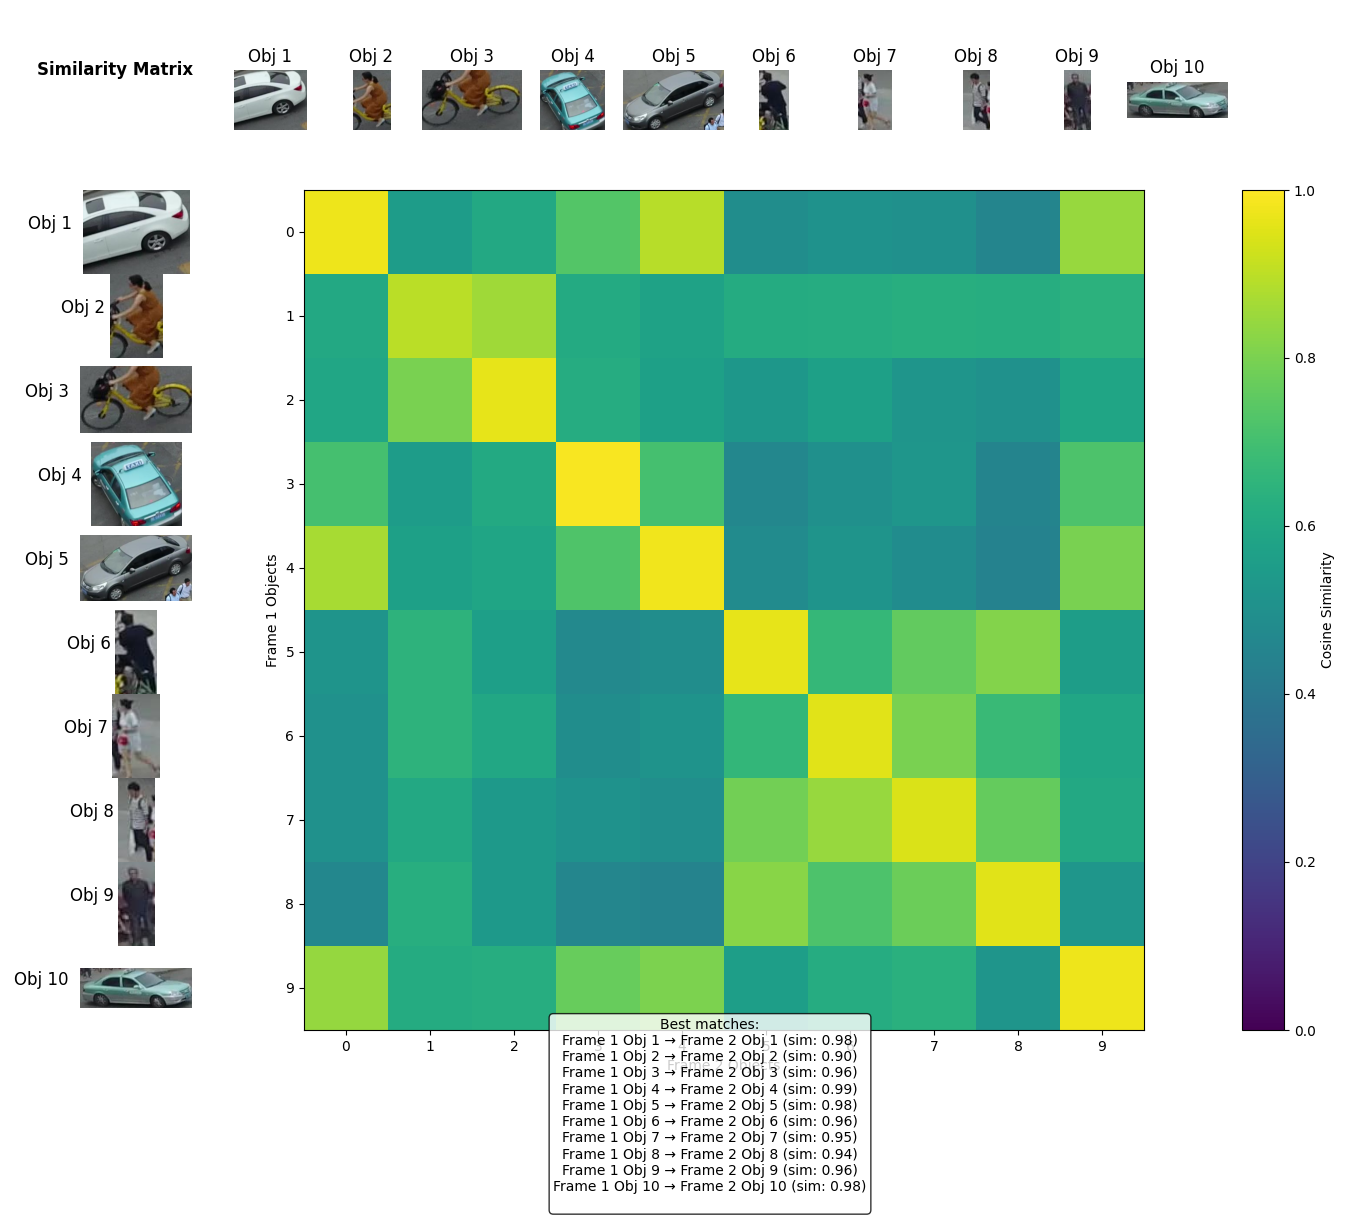

In [77]:
similarity_matrix = track_and_visualize(instance_imgs_frames[0], instance_imgs_frames[1])

# Test Build graph

In [100]:
import os, time
import cv2, random
import pickle, joblib
import sklearn.metrics
import numpy as np
np.set_printoptions(suppress=True)
import gurobipy as gp

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data

from lib.tracking import Tracker
from lib.utils import getIoU, computeBoxFeatures, interpolateTrack, interpolateTracks

In [78]:
seq = 'MOT17-01'
detector = 'DPM'

In [80]:
det_file = './result/{}/det_{}.txt'.format(seq, detector)
app_file = './result/{}/app_det_{}.npy'.format(seq, detector)
dets = np.loadtxt(det_file, delimiter=',')
app_feats = np.load(app_file)
assert dets.shape[0] == app_feats.shape[0], 'Shape mismatch'

In [90]:
dets[:10]

array([[          1,          -1,         770,         460,          40,         127,           1,          -1,          -1,          -1],
       [          1,          -1,         465,         467,          46,         106,        0.97,          -1,          -1,          -1],
       [          1,          -1,        1224,         455,          56,         173,           1,          -1,          -1,          -1],
       [          1,          -1,         718,         456,          43,         132,           1,          -1,          -1,          -1],
       [          1,          -1,         995,         455,          69,         191,           1,          -1,          -1,          -1],
       [          1,          -1,         671,         460,          28,          87,        0.84,          -1,          -1,          -1],
       [          2,          -1,         465,         467,          47,         110,        0.99,          -1,          -1,          -1],
       [          2,       

In [98]:
start_frame = 0
end_frame = 15
app_thresh = 0.75

In [88]:
curr_ind = np.logical_and(dets[:, 0] >= start_frame, dets[:, 0] <= end_frame)
curr_dets = np.concatenate([dets[curr_ind, 0][:, None], dets[curr_ind, 2:7],
                            np.arange(dets[curr_ind].shape[0])[:, None]], axis=1)

curr_dets[:, 3:5] = curr_dets[:, 3:5] + curr_dets[:, 1:3] # convert to frame,x1,y1,x2,y2,conf,node_ind
curr_app_feats = app_feats[curr_ind]
curr_app_feats = curr_app_feats / np.linalg.norm(curr_app_feats, axis=1, keepdims=True)

In [94]:
curr_app_feats.shape

(104, 512)

In [96]:
def get_trans_probs(curr_dets, curr_app_feats, app_thresh, max_frame_gap = 5):
    """
    Inputs: tracker: an instance of the Tracker.
            curr_dets: frame, x1, y1, x2, y2, det_confidence, node_ind.
            curr_app_feats: normalized appearance features for curr_dets.
            max_frame_gap: frame gap used to connect detections.
    Return: transition probabilities for LP that handles false negatives(missing detections).
    """
    edge_ind = 0
    edge_feats, lifted_probs = [], []
    edge_type = [] #1:base edge 2:lifted edge-1:pruned lifted edge
    
    cos_sim_mat = np.dot(curr_app_feats, curr_app_feats.T)
    linkIndexGraph = np.zeros((curr_dets.shape[0], curr_dets.shape[0]), dtype=np.int32)
    for i in range(curr_dets.shape[0]):
        for j in range(curr_dets.shape[0]):
            frame_gap = curr_dets[j][0] - curr_dets[i][0]
            cos_sim = cos_sim_mat[i, j]

            if frame_gap == 1: #base edge
                edge_type.append(1)
                feats = computeBoxFeatures(curr_dets[i, 1:5], curr_dets[j, 1:5])
                iou = getIoU(curr_dets[i, 1:5], curr_dets[j, 1:5])
                feats.extend((iou, cos_sim))
                edge_feats.append(feats)
                edge_ind += 1
                linkIndexGraph[i, j] = edge_ind

            elif frame_gap > 1 and frame_gap <= max_frame_gap: #lifted edge
                if cos_sim > app_thresh:
                    edge_type.append(2)
                    time_weight = 0.9 ** frame_gap
                    lifted_probs.append(cos_sim * time_weight)
                else:
                    edge_type.append(-1)

                edge_ind += 1
                linkIndexGraph[i, j] = edge_ind
    return linkIndexGraph

In [102]:
linkIndexGraph = get_trans_probs(curr_dets, curr_app_feats, app_thresh, max_frame_gap = 5)

In [103]:
linkIndexGraph

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)